# Unbinned Profiled Unfolding

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate simulation and data events from Gaussian distribution

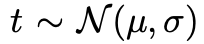

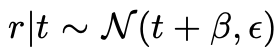

In [2]:
Ndata = 1000
Nsim = 1000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

In [3]:
bins = np.linspace(-3,3,10)

Define w0 (parameters: sigma, mu (correspond to simulation), a, b (correspond to data)), 

and w1 (parameters: epsilon, beta (correspond to simulation), c, d (correspond to data))
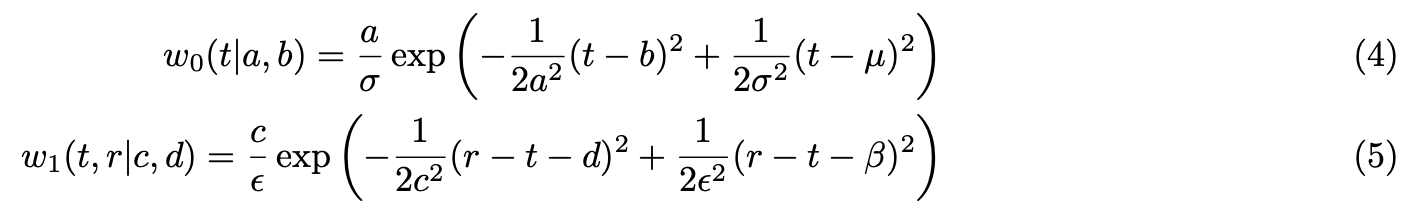

In [4]:
def gauss_ratio(x,sigma,mu,a,b):
    return (a/sigma)*np.exp(-0.5*(x-b)**2/a**2+0.5*(x-mu)**2/sigma**2)

def w0(t,sigma,mu,a,b):
    return gauss_ratio(t,sigma,mu,a,b)

def w1(r,t,epsilon,beta,c,d):
    return gauss_ratio(r,epsilon,t+beta,c,t+d)

def log_gauss(x,sigma,mu):
    return -0.5*(x-mu)**2/sigma**2

Scan through b and c and fix all the other parameters

Calculate likelihood scan

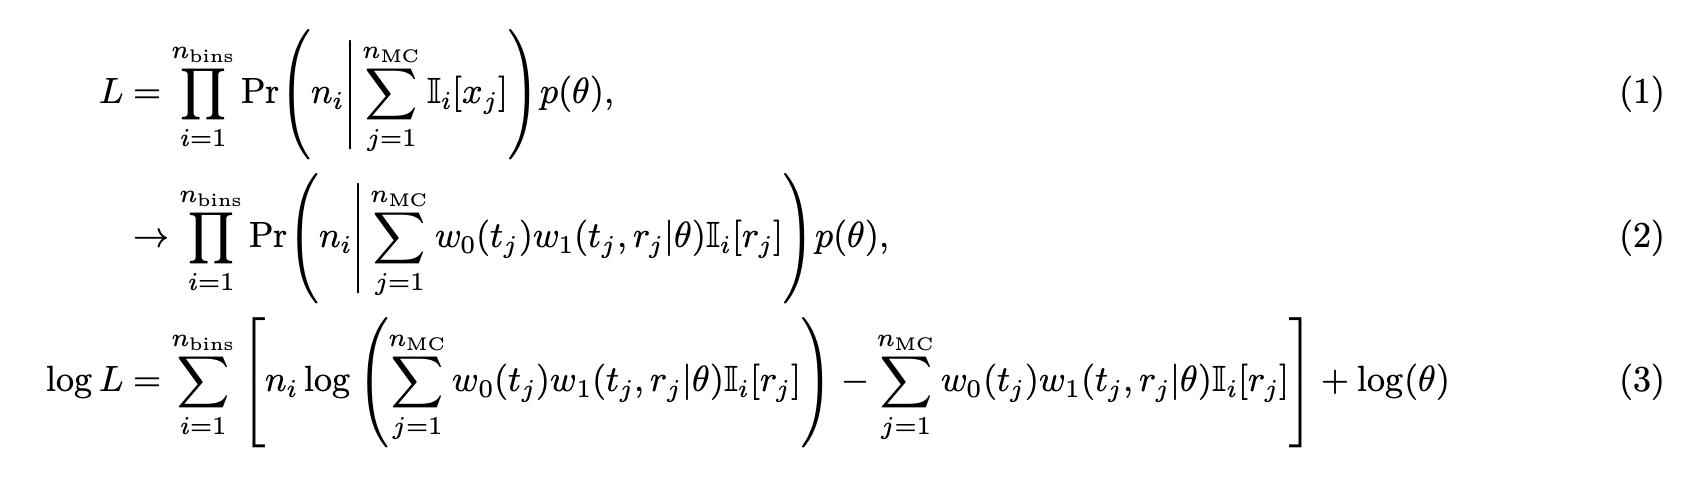

In [5]:
lls = []
for test_mu in np.linspace(-0.5,0.5,50):
    #print(test_mu)
    lls += [[]]
    for test_epsilon in np.linspace(0.8,1.2,50):
        per_bin = 0
        for i in range(len(bins)):
            mysum = np.sum((np.digitize(R_sim,bins)==i)*w0(T_sim,sigma_sim,mu_sim,1,test_mu)*w1(R_sim,T_sim,epsilon_sim,beta_sim,test_epsilon,0))
            ni = np.sum((np.digitize(R_data,bins)==i))
            if (mysum > 0):
                per_bin+=ni*np.log(mysum) - mysum + log_gauss(test_epsilon,epsilon_sim*0.1,epsilon_sim)
            pass
        lls[-1] += [per_bin]

Text(0.5, 1.0, 'Log Likelihood')

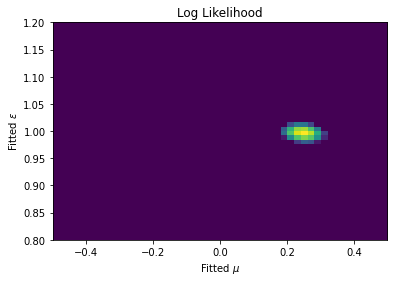

In [6]:
extent = -0.5, 0.5,0.8, 1.2
lls = np.array(lls)
plt.imshow(lls.T, extent=extent, aspect='auto', vmin = np.max(lls)-1, vmax = np.max(lls))
plt.xlabel("Fitted $\mu$")
plt.ylabel("Fitted $\epsilon$")
plt.title("Log Likelihood")

## Now try to solve the problem with deep learning!

In [7]:
%load_ext tensorboard
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [8]:
Ndata = 1000
Nsim = 100000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

epsilons_sim_random = np.random.uniform(0.8, 1.2, Nsim) # used for training
epsilons_sim_theta = np.random.uniform(0.8, 1.2, Nsim)
R_sim_theta = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R_sim_theta.append(np.random.normal(T_sim[i]+beta_sim,epsilons_sim_theta[i]))
R_sim_theta = np.array(R_sim_theta)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

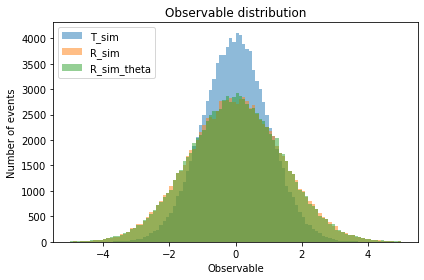

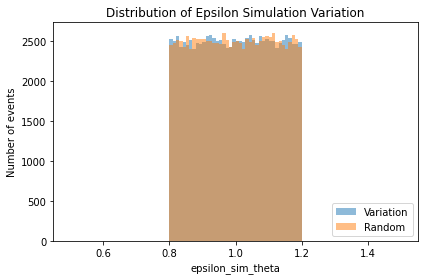

In [9]:
plt.hist(T_sim, range=(-5, 5), density=False, bins=100, label="T_sim", alpha=0.5)
plt.hist(R_sim, range=(-5, 5), density=False, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_sim_theta, range=(-5, 5), density=False, bins=100, label="R_sim_theta", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilons_sim_theta, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.hist(epsilons_sim_random, range=(0.5, 1.5), density=False, bins=100, label="Random", alpha=0.5)
plt.xlabel('epsilon_sim_theta')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [10]:
class w1_dataset(Dataset):
    def __init__(self, T0, R0, R1, epsilon0, epsilon1):
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.epsilon0 = epsilon0
        self.epsilon1 = epsilon1
        self.inds = np.random.randint(0,len(R1),len(R0))
        
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            data = torch.tensor([self.R0[i], self.epsilon0[i], self.T0[i], self.T0[self.inds[i]]]) # use the same T_sim for R_sim variation
        else:
            data = torch.tensor([self.R1[self.inds[i]], self.epsilon1[self.inds[i]], self.T0[i], self.T0[self.inds[i]]])
        return data, label
    
# Do we standardize the input variables?

# class w1_dataset_0(Dataset):
#     def __init__(self, T, R, epsilon):
#         self.T = T
#         self.R = R
#         self.epsilon = epsilon
#         return
        
#     def __len__(self):
#         return len(self.R)

#     def __getitem__(self, idx):
#         data = torch.tensor([self.R[idx], self.epsilon, self.T[idx], self.T[idx]])
#         return data, 1

In [11]:
w1_ds = w1_dataset(T_sim, R_sim, R_sim_theta, epsilons_sim_random, epsilons_sim_theta)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=1000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=1000, shuffle=False, num_workers=12)

In [12]:
# batch = next(iter(w1_dataloader_train))
# print(batch)

In [13]:
import sys, os

class w1(LightningModule):
    def __init__(self, device="cpu"):
        super(w1, self).__init__()
        self.dvc = device
        self.loss_fn = nn.BCELoss()
        self.epoch = 0
        
        # currently using the less constrained model
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.add_module("linear_1", nn.Linear(4, 50))
        self.linear_relu_stack.add_module("relu_1", nn.ReLU())
        self.linear_relu_stack.add_module("linear_2", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_2", nn.ReLU())
        self.linear_relu_stack.add_module("linear_3", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_3", nn.ReLU())
        self.linear_relu_stack.add_module("linear_4", nn.Linear(50, 1))
        self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def training_epoch_end(self, training_step_outputs):
        self.training_loss = 0
        scores, ys = None, None
        for training_step_output in training_step_outputs:
            self.training_loss += torch.mul(training_step_output["loss"], len(training_step_output["target"])).item()
            scores = torch.cat([scores, training_step_output["score"]]) if scores is not None else training_step_output["score"]
            ys = torch.cat([ys, training_step_output["target"]]) if ys is not None else training_step_output["target"]

        self.training_loss /= len(ys)

        scores = scores.cpu().numpy().reshape(-1)
        ys = ys.cpu().numpy()
        self.training_acc = accuracy_score(ys, scores>0.5)

        self.log("train_loss", self.training_loss)
        self.log("train_acc", self.training_acc)

#         sys.stdout.write('\033[2K\033[1G')
#         sys.stdout.write(f'Epoch {self.epoch}: Train loss - {self.training_loss}, Val loss - {self.validation_loss}\n')
        print("\r"+" "*(os.get_terminal_size().columns-1), end="")
        print("\r"+f'Epoch {self.epoch}: Train loss - {self.training_loss}, Train acc - {self.training_acc}, Val loss - {self.validation_loss}, Val acc - {self.validation_acc}')
        self.epoch += 1

    def validation_epoch_end(self, validation_step_outputs):
        self.validation_loss = 0
        scores, ys = None, None
        for validation_step_output in validation_step_outputs:
#             self.validation_loss += torch.mul(validation_step_output["loss"], len(validation_step_output["target"])).item()
            scores = torch.cat([scores, validation_step_output["score"]]) if scores is not None else validation_step_output["score"]
            ys = torch.cat([ys, validation_step_output["target"]]) if ys is not None else validation_step_output["target"]

#         self.validation_loss /= len(ys)
        self.validation_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        scores = scores.cpu().numpy().reshape(-1)
        ys = ys.cpu().numpy()
        self.validation_acc = accuracy_score(ys, scores>0.5)

        self.log("val_loss", self.validation_loss)
        self.log("val_acc", self.validation_acc)

    def test_epoch_end(self, test_step_outputs):
        self.test_loss = 0
        scores, ys = None, None
        for test_step_output in test_step_outputs:
            # self.test_loss += torch.mul(test_step_output["loss"], len(test_step_output["target"])).item()
            scores = torch.cat([scores, test_step_output["score"]]) if scores is not None else test_step_output["score"]
            ys = torch.cat([ys, test_step_output["target"]]) if ys is not None else test_step_output["target"]

#         self.test_loss /= len(ys)
        self.test_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        self.test_scores = scores.cpu().numpy().reshape(-1)
        self.test_ys = ys.cpu().numpy()

        self.log("test_loss", self.test_loss)
        self.test_acc = accuracy_score(self.test_ys, self.test_scores>0.5)

        # sys.stdout.write('Finished. \n')
        # sys.stdout.write(f'Test loss - {self.test_loss} \n')

    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [14]:
model_w1 = w1(device=dvc).double().to(dvc)
print(model_w1)

w1(
  (loss_fn): BCELoss()
  (linear_relu_stack): Sequential(
    (linear_1): Linear(in_features=4, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=50, bias=True)
    (relu_3): ReLU()
    (linear_4): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [15]:
from tqdm import tqdm
from pytorch_lightning.callbacks import ProgressBar

class LitProgressBar(ProgressBar):
   
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

bar = LitProgressBar()

callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, check_finite=True), bar]
callbacks.append(ModelCheckpoint(
    save_top_k=1,
    monitor='val_loss',
    mode='min',
    dirpath='model/w1',
    filename='best',
))

trainer = Trainer(accelerator=device, devices=1, callbacks=callbacks, default_root_dir='model/w1')

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/progress/progress.py:22: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(model_w1, w1_dataloader_train, w1_dataloader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | loss_fn           | BCELoss    | 0     
1 | linear_relu_stack | Sequential | 5.4 K 
-------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /afs/cern.ch/work/c/cchan/UnbinnedProfiledUnfolding/model/w1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Epoch 0: Train loss - 0.5943379404843157, Train acc - 0.6729, Val loss - 0.545506633945431, Val acc - 0.6933                                                                                                                            
Epoch 1: Train loss - 0.5398217796244035, Train acc - 0.69468, Val loss - 0.5425960669516288, Val acc - 0.69377                                                                                                                         
Epoch 2: Train loss - 0.5384820925229354, Train acc - 0.69421, Val loss - 0.5429009742543959, Val acc - 0.69124                                                                                                                         
Epoch 3: Train loss - 0.5370946464326012, Train acc - 0.69524, Val loss - 0.544073475730882, Val acc - 0.68953                                                                                                                          
Epoch 4: Train loss - 0.5370148636524529, Train acc - 0.69492, Val l

Epoch 35: Train loss - 0.5336313975176199, Train acc - 0.69828, Val loss - 0.5386222583868421, Val acc - 0.69608                                                                                                                        
Epoch 36: Train loss - 0.5339629161032788, Train acc - 0.69737, Val loss - 0.5382632069908633, Val acc - 0.69594                                                                                                                        
Epoch 37: Train loss - 0.5336279742106986, Train acc - 0.6988, Val loss - 0.5383175584154455, Val acc - 0.69585                                                                                                                         
Epoch 38: Train loss - 0.5337000517369823, Train acc - 0.69803, Val loss - 0.5383432635352039, Val acc - 0.69607                                                                                                                        
Epoch 39: Train loss - 0.5335304929366017, Train acc - 0.69979, Val 

In [17]:
# !tensorboard --logdir .

In [18]:
###### TEST W1 PERFORMANCE #####

Nsim = 100000

mu_sim_test = 0
sigma_sim_test = 1
beta_sim_test = 0
epsilon_sim_test_0 = 1
epsilon_sim_test_1 = 1.2

T_sim_test_1 = np.random.normal(mu_sim_test, sigma_sim_test, Nsim)
R_sim_test_1 = np.random.normal(T_sim_test_1 + beta_sim_test, epsilon_sim_test_1)

T_sim_test_0 = np.random.normal(mu_sim_test, sigma_sim_test, Nsim)
R_sim_test_0 = np.random.normal(T_sim_test_0 + beta_sim_test, epsilon_sim_test_0)
x_sim_test_0 = np.c_[R_sim_test_0, np.ones(Nsim) * epsilon_sim_test_1, T_sim_test_0, T_sim_test_0]
x_sim_test_0 = torch.from_numpy(x_sim_test_0).to(dvc)

# print(T_sim_0.shape, R_sim_0.shape)
# w1_ds_0 = w1_dataset_0(T_sim_0, R_sim_0, epsilon_sim_prime)
# w1_dataloader_0 = DataLoader(w1_ds_0, batch_size=64, shuffle=False, num_workers=12)

# load checkpoint
checkpoint = "model/w1/best.ckpt"
model_w1 = w1.load_from_checkpoint(checkpoint, device=dvc).double().to(dvc)
model_w1.eval()
scores = model_w1(x_sim_test_0).detach().cpu().numpy().reshape(-1)

# trainer.test(model=model_w1, dataloaders=w1_dataloader_0, ckpt_path=checkpoint)
# scores = model_w1.test_scores
weights = (1. - scores) / scores

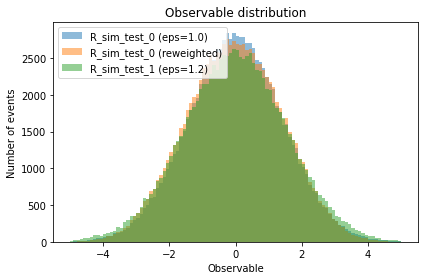

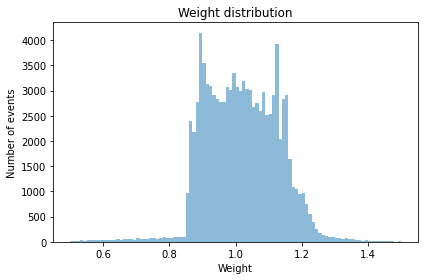

In [19]:
plt.hist(R_sim_test_0, range=(-5, 5), density=False, bins=100, label="R_sim_test_0 (eps=1.0)", alpha=0.5)
plt.hist(R_sim_test_0, weights=weights, range=(-5, 5), density=False, bins=100, label="R_sim_test_0 (reweighted)", alpha=0.5)
plt.hist(R_sim_test_1, range=(-5, 5), density=False, bins=100, label="R_sim_test_1 (eps=1.2)", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(weights, range=(0.5, 1.5), density=False, bins=100, label="R_sim", alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Number of events')
plt.title(r'Weight distribution')
# plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()